<a href="https://www.kaggle.com/code/albertomonedero/fashioncnn?scriptVersionId=126170009" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SISTEMA DE RECOMENDACIÓN DE ARTÍCULOS DE MODA

In [1]:
from numpy import loadtxt
import pandas as pd
from PIL import Image
from fastcore.all import *
from torch.utils.data import Dataset ,DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torch
import numpy
from torch import nn
import torchmetrics as metrics
import pytorch_lightning as pl



dataFrame = pd.read_csv('../input/fashion-product-images-small/styles.csv',on_bad_lines='skip').dropna()
dataFrame


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [2]:
import sys
print(sys.version)
print(numpy.__version__)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
1.21.6


# **Preparación de los datos de entrada (CSV)**
Como quiero clasificar las prendas únicamente por género y estilo, creo un nuevo csv a mi gusto, quedándome sólo con dos columnas:
* image = nombre del archivo de imagen, ej ->"15970.jpg".
* target = columna objetivo,representada por un entero que equivale a un usage+gender concreto
            ej -> "0", que sería CasualMen.**

Además debo eliminar ciertas entradas del csv original erróneas, ya que existen algunas entradas con ids que no se corresponden a ninguna imágen de la carpeta de imágenes.


In [3]:
#creo la columna image con id+.jpg y la columna target con usage+gender

def getImageName(id): return '{name}.jpg'.format(name = id)

dataFrame['image'] = dataFrame['id'].map(getImageName)
dataFrame['target'] =dataFrame['usage']+dataFrame['gender']

dataFrame.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,target
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,CasualMen
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,CasualMen
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,CasualWomen
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,CasualMen
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,CasualMen


In [4]:
#nos quedamos solo con las columnas image y target
ds = dataFrame.filter(['image', 'target'])
ds.head()


,image,target
0,15970.jpg,CasualMen
1,39386.jpg,CasualMen
2,59263.jpg,CasualWomen
3,21379.jpg,CasualMen
4,53759.jpg,CasualMen


In [5]:
#Tenemos 25 clases objetivo en nuestro dataframe
targets=ds.target.unique()
CLASSES=len(targets)
print(CLASSES)
print(targets)

25
['CasualMen' 'CasualWomen' 'EthnicMen' 'CasualBoys' 'FormalMen'
 'CasualGirls' 'CasualUnisex' 'SportsMen' 'EthnicWomen' 'SportsWomen'
 'FormalWomen' 'SportsUnisex' 'SportsBoys' 'Smart CasualWomen'
 'TravelUnisex' 'Smart CasualMen' 'PartyWomen' 'EthnicBoys' 'EthnicGirls'
 'TravelWomen' 'HomeUnisex' 'PartyMen' 'SportsGirls' 'TravelMen'
 'FormalUnisex']


In [6]:
#Creo un diccionario para mapear targets con enteros
#Sustituyo en el dataFrame el nombre de los targets por el número correspondiente en dicho diccionario
i=0
classDic={}
for t in targets:
    ds['target']=ds['target'].replace(t,i)
    classDic[i]=t
    i+=1
print(ds)
print(classDic)

           image  target
0      15970.jpg       0
1      39386.jpg       0
2      59263.jpg       1
3      21379.jpg       0
4      53759.jpg       0
...          ...     ...
44419  17036.jpg       0
44420   6461.jpg       0
44421  18842.jpg       0
44422  46694.jpg       1
44423  51623.jpg       1

[44077 rows x 2 columns]
{0: 'CasualMen', 1: 'CasualWomen', 2: 'EthnicMen', 3: 'CasualBoys', 4: 'FormalMen', 5: 'CasualGirls', 6: 'CasualUnisex', 7: 'SportsMen', 8: 'EthnicWomen', 9: 'SportsWomen', 10: 'FormalWomen', 11: 'SportsUnisex', 12: 'SportsBoys', 13: 'Smart CasualWomen', 14: 'TravelUnisex', 15: 'Smart CasualMen', 16: 'PartyWomen', 17: 'EthnicBoys', 18: 'EthnicGirls', 19: 'TravelWomen', 20: 'HomeUnisex', 21: 'PartyMen', 22: 'SportsGirls', 23: 'TravelMen', 24: 'FormalUnisex'}


In [7]:

#Procedo a eliminar las filas con ids de imágenes que no existen en la carpeta de imágenes
images=ds.image.unique()
imagenes_existentes=os.listdir('../input/fashion-product-images-small/images')
for i in images:
    if(i not in imagenes_existentes):
        ds=ds.drop(ds[ds['image']==i].index)

In [8]:
#guardo mi nuevo dataframe en un csv
ds.to_csv('custom.csv',index=False)


# Creación del dataset personalizado

In [9]:
transformaciones = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(), #0 - 255--->0 - 1
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #0 - 1--->-1 - 1
                                     ])
batch_size = 64

In [10]:

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file, on_bad_lines='skip')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        image = self.transform(image)

        return (image, y_label)


#Instanciamos el dataset con nuestro csv personalizado, las imágenes 
#y las transformaciones que se le aplican a las mismas 
dataset = CustomDataset(
    csv_file="./custom.csv",
    root_dir="../input/fashion-product-images-small/images/",
    transform=transformaciones,
)
print(len(dataset))

44072


In [11]:
torch.cuda.is_available()

True

In [12]:
#Dividimos el dataset en 3:entrenamiento, validación y test, y creamos los dataloaders
train_set,val_set, test_set = torch.utils.data.random_split(dataset, [30000, 9072,5000])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, num_workers=2)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,  num_workers=2)

# Primera Fase: CNN para clasificar imágenes por género y estilo.


# Creación del Modelo CNN

In [13]:
class CNNModel(pl.LightningModule):
    def __init__(self):
        #shape=[batchsize,canalesentrada,alto,ancho]
        #entrada [64, 3, 64, 64])
        super().__init__()
    #EXTRACCIÓN DE CARACTERÍSTICAS
        #1 BLOQUE CONV
        self.cnv = nn.Conv2d(3,40,5,2)#[64, 40, 30, 30]
        self.rel = nn.ReLU()                    
        self.bn = nn.BatchNorm2d(40)  
        self.mxpool = nn.MaxPool2d(2)#[64, 40, 15, 15]
        #2 BLOQUE CONV
        self.cnv2 = nn.Conv2d(40,55,5,2)#[64, 55, 6, 6])
        self.rel2 = nn.ReLU()                    
        self.bn2 = nn.BatchNorm2d(55)  
        self.mxpool2 = nn.MaxPool2d(2)#[64, 55, 3, 3]
        
        
    #CARACTERIZACIÓN
        self.flat = nn.Flatten()#[64,55x3x3=495]
        self.fc1 = nn.Linear(495,495)
        self.fc2 = nn.Linear(495,300)
        self.fc3 = nn.Linear(300,CLASSES)
        self.softmax = nn.Softmax()
        self.accuracy = metrics.Accuracy(task='multiclass',num_classes=25) #predicciones correctas/total de predicciones

    def forward(self,x):
       # print('antes conv',x.shape)
        out = self.cnv(x)
        #print('despues conv',out.shape)
        out = self.rel(out)
       # print('despues relu',out.shape)
        out = self.bn(out)
        #print('despues batchnorm',out.shape)
        out = self.mxpool(out)
        #rint('despues maxpool',out.shape)
        
        
        out = self.cnv2(out)
        #print('despues conv2',out.shape)
        out = self.rel2(out)
        #print('despues relu2',out.shape)
        out = self.bn2(out)
        #print('despues batchnorm2',out.shape)
        out = self.mxpool2(out)
       # print('despues maxpool2',out.shape)
        
        out = self.flat(out)
       # print('despues flat',out.shape)
        out = self.rel(self.fc1(out))
        out = self.rel(self.fc2(out))   
        out = self.fc3(out)
        return out

    def loss_fn(self,out,target):
        return nn.CrossEntropyLoss()(out.view(-1,CLASSES),target)
    
    def configure_optimizers(self):
        LR = 1e-3
        optimizer = torch.optim.AdamW(self.parameters(),lr=LR)
        return optimizer
    
    def predict(self, x):
        with torch.no_grad():
            out = self(x)
            out=nn.Softmax(-1)(out)
            return torch.argmax(out, axis=1)

    def training_step(self,batch,batch_idx):
        x,y = batch
        imgs = x.view(-1,3,64,64)
        labels = y.view(-1)
        out = self(imgs)
        loss = self.loss_fn(out,labels)
        out = nn.Softmax(-1)(out)
        logits = torch.argmax(out,dim=1)
        accu = self.accuracy(logits, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', accu, prog_bar=True)
        return loss       

    def validation_step(self,batch,batch_idx):
        x,y = batch
        imgs = x.view(-1,3,64,64)
        labels = y.view(-1)
        out = self(imgs)
        loss = self.loss_fn(out,labels)
        out = nn.Softmax(-1)(out) 
        logits = torch.argmax(out,dim=1)
        accu = self.accuracy(logits, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', accu, prog_bar=True)
        return loss, accu

In [14]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [15]:
mod = CNNModel().to(device)


Exportamos el modelo en formato ONNX para hacer uso de la aplicación Netron, que permite visualizar la arquitectura de un modelo de deep learning.


In [16]:
import torch.onnx

input_names = ["input"]
output_names = ["output"]



batch=next(iter(test_loader)) #cogemos 1 lote, batch=[[imgs],[labels]]
imgs, labels= batch[0],batch[1]



# Exportamos el modelo a ONNX
torch.onnx.export(mod, imgs.to(device), "model.onnx", input_names=input_names, output_names=output_names, opset_version=11)


# Entrenamiento del modelo


In [17]:
mod.train()
trainer = pl.Trainer(accelerator='gpu',devices=1,
                     max_epochs=4
                    
)
trainer.fit(mod,train_loader,val_loader) 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [18]:
#Guardamos el estado del modelo entrenado
state_dict = mod.state_dict()
torch.save(state_dict, "prueba7.pth")

# Pruebas: Calcular el rendimiento con datos de Test y probar a predecir una imágen


In [17]:
#Cargo mi modelo ya entrenado
state = torch.load("../input/modelo6/prueba6.pth") #por ahora modelo 6 es el mejor

new_model =CNNModel()
new_model.load_state_dict(state)

<All keys matched successfully>

In [18]:
print(len(test_set),len(test_loader))

5000 79


In [19]:
    #Calculamos la acc y loss del modelo 
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss=0
        new_model.eval()
        for data, target in test_loader: #vamos iterando los distintos lotes del test_loader
            images = data
            labels =target
            outputs = new_model(images)
            total_loss+=new_model.loss_fn(outputs,labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        print('loss',total_loss/len(test_loader))  #divido la perdida en cada lote por el numero de lotes
 


Test Accuracy of the model: 83.9 %
loss tensor(0.4606)


valor esperado: CasualMen


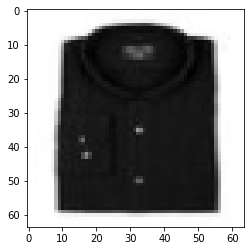

In [20]:
#PROBAMOS A PREDECIR 1 DE LAS IMAGENES DEL TEST_LOADER
import matplotlib.pyplot as plt 

batch=next(iter(test_loader)) #cogemos 1 lote, batch=[[imgs],[labels]]
imgs, labels= batch[0],batch[1]
im=imgs[1]
label=labels[1]
plt.imshow(im.numpy()[0], cmap='gray')
print("valor esperado:",classDic[label.item()])


In [21]:
output = new_model(im.unsqueeze(0))
_, predicted = torch.max(output, 1)
etiqueta =classDic[predicted.item()]
print('Valor predicho: ',etiqueta )

Valor predicho:  CasualMen


In [22]:
#lo mismo pero probando la función predict del modelo
prediction = new_model.predict(im.unsqueeze(0))

etiqueta2=classDic[prediction.item()]
print('Valor predicho: ',etiqueta2 )

Valor predicho:  CasualMen


# Segunda Fase: Tras clasificar una prenda, obtener los candidatos a recomendar (aquellos con la misma etiqueta) y devolver los N candidatos más parecidos.


Clasifico una prenda

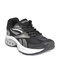

In [23]:
#imagen a clasificar
img = Image.open('../input/fashion-product-images-small/images/10080.jpg')
img

In [24]:
#clasificar dicha imagen
t_img = transformaciones(img).unsqueeze(0)
output = new_model(t_img)
_, predicted = torch.max(output, 1)
etiqueta =classDic[predicted.item()]
print('Valor predicho: ',etiqueta )


Valor predicho:  SportsMen


In [25]:
#lo mismo pero usando la función prediction definida en el modelo
t_img = transformaciones(img).unsqueeze(0)
prediction = new_model.predict(t_img)

etiqueta2=classDic[prediction.item()]
print('Valor predicho: ',etiqueta2 )

Valor predicho:  SportsMen


A continuación, devuelvo los posibles candidatos ( en este caso, prendas deportivas de hombre)

In [26]:
print(ds)
print(classDic)

           image  target
0      15970.jpg       0
1      39386.jpg       0
2      59263.jpg       1
3      21379.jpg       0
4      53759.jpg       0
...          ...     ...
44419  17036.jpg       0
44420   6461.jpg       0
44421  18842.jpg       0
44422  46694.jpg       1
44423  51623.jpg       1

[44072 rows x 2 columns]
{0: 'CasualMen', 1: 'CasualWomen', 2: 'EthnicMen', 3: 'CasualBoys', 4: 'FormalMen', 5: 'CasualGirls', 6: 'CasualUnisex', 7: 'SportsMen', 8: 'EthnicWomen', 9: 'SportsWomen', 10: 'FormalWomen', 11: 'SportsUnisex', 12: 'SportsBoys', 13: 'Smart CasualWomen', 14: 'TravelUnisex', 15: 'Smart CasualMen', 16: 'PartyWomen', 17: 'EthnicBoys', 18: 'EthnicGirls', 19: 'TravelWomen', 20: 'HomeUnisex', 21: 'PartyMen', 22: 'SportsGirls', 23: 'TravelMen', 24: 'FormalUnisex'}


In [27]:
#Creo una condición para obtener candidatas del dataframe
condicion_etiqueta = ds['target'] == predicted.item()
condicion_etiqueta.head()
            

0    False
1    False
2    False
3    False
4    False
Name: target, dtype: bool

In [28]:
candidatas=ds[condicion_etiqueta]
print(candidatas)

           image  target
23     13089.jpg       7
27      7990.jpg       7
45      3168.jpg       7
46     18005.jpg       7
67      6628.jpg       7
...          ...     ...
44400  10021.jpg       7
44401  24214.jpg       7
44404   4336.jpg       7
44412   1644.jpg       7
44414  30614.jpg       7

[2946 rows x 2 columns]


# Función para devolver las N candidatas más parecidas a una imagen dada

Uso la librería img2vect de pytorch que usa modelos pre-entrenados (en mi caso resnet-18) para obtener la representación vectorial de las imágenes, y después calcular la similitud usando como función la similitud coseno.

In [29]:
pip install img2vec-pytorch

Note: you may need to restart the kernel to use updated packages.


In [31]:
from img2vec_pytorch import Img2Vec
img2vec = Img2Vec(cuda=True, model='resnet-18')
cos = nn.CosineSimilarity(eps=1e-6)
imagenes=candidatas.image.unique()

In [32]:

def N_mas_parecidas(imagen,n,imagenes):
   
    vec1 = img2vec.get_vec(imagen, tensor=True).reshape(512) #representación vectorial imagen de entrada
    dic={}#diccionario con imagenes y similitudes
    similitudes=[]
    recomendadas={}
    for im in imagenes: #cargo el diccionario con cada imagen como clave y la similitud como valor
                        #y obtengo una lista con las n mayores similitudes, ordenada de mayor a menor
        candidata = Image.open('../input/fashion-product-images-small/images/'+im)       
        vec2 = img2vec.get_vec(candidata.convert('RGB'), tensor=True).reshape(512)
        cos_sim = cos(vec1.unsqueeze(0),vec2.unsqueeze(0))
        if(cos_sim!=1): #no quiero devolver la propia imagen cono recomendación
            dic[im]=cos_sim
            similitudes.append(cos_sim)
    n_mayor_similitud=sorted(list(set(similitudes)), reverse=True)[:n]
    for im in imagenes:
        if(dic.get(im) in n_mayor_similitud):
            recomendadas[im]=dic.get(im)
            
    return recomendadas 

**Versión optimizada utilizando librería heapq para algoritmo de montículo**

In [33]:
import heapq

def N_mas_parecidas_optimizada(imagen,n,imagenes):
    
    vec1 = img2vec.get_vec(imagen, tensor=True).reshape(512) #representación vectorial imagen de entrada
   
    heap=[] #lista de tuplas (similitud,imagen)

    for im in imagenes: 
        candidata = Image.open('../input/fashion-product-images-small/images/'+im)       
        vec2 = img2vec.get_vec(candidata.convert('RGB'), tensor=True).reshape(512)
        cos_sim = cos(vec1.unsqueeze(0),vec2.unsqueeze(0))
        if(cos_sim<1): #no quiero devolver la propia imagen cono recomendación
            
            heapq.heappush(heap, (round(cos_sim.item(),7), im))
    
    
    return heapq.nlargest(n, heap) 

Probamos la función

In [79]:
dic=N_mas_parecidas(img,5,imagenes)

similares=[]
for nombre in dic.keys():
     similares.append(nombre)
print(dic)
print(similares)
rec1 = Image.open('../input/fashion-product-images-small/images/'+similares[0]) 
rec2 = Image.open('../input/fashion-product-images-small/images/'+similares[1]) 
rec3 = Image.open('../input/fashion-product-images-small/images/'+similares[2]) 
rec4 = Image.open('../input/fashion-product-images-small/images/'+similares[3]) 
rec5 = Image.open('../input/fashion-product-images-small/images/'+similares[4]) 
 

{'34643.jpg': tensor([0.9125]), '15284.jpg': tensor([0.9202]), '4448.jpg': tensor([0.9144]), '8075.jpg': tensor([0.9220]), '4996.jpg': tensor([0.9139])}
['34643.jpg', '15284.jpg', '4448.jpg', '8075.jpg', '4996.jpg']


imagen clasificada:

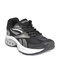

In [80]:
img  

recomendaciones:

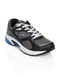

In [81]:
rec1

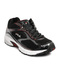

In [82]:
rec2

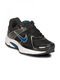

In [68]:
rec3

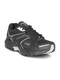

In [77]:
rec4

In [35]:
lista=N_mas_parecidas_optimizada(img,5,imagenes)

similares=[]
for tupla in lista:
     similares.append(tupla[1])
print(lista)
print(similares)
rec1 = Image.open('../input/fashion-product-images-small/images/'+similares[0]) 
rec2 = Image.open('../input/fashion-product-images-small/images/'+similares[1]) 
rec3 = Image.open('../input/fashion-product-images-small/images/'+similares[2]) 
rec4 = Image.open('../input/fashion-product-images-small/images/'+similares[3]) 
rec5 = Image.open('../input/fashion-product-images-small/images/'+similares[4]) 

[(0.9219512, '8075.jpg'), (0.9202313, '15284.jpg'), (0.9144138, '4448.jpg'), (0.9139409, '4996.jpg'), (0.9124635, '34643.jpg')]
['8075.jpg', '15284.jpg', '4448.jpg', '4996.jpg', '34643.jpg']


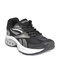

In [36]:
img

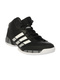

In [37]:
rec1

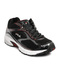

In [38]:
rec2

# COMPARACIÓN DEL RENDIMIENTO DE MI CNN CLASIFICADORA CON OTRAS PRE-ENTRENADAS


Para usar los modelos pre-entrenados para clasificar un dataset propio hay que re-entrenarlos con mi propio dataset. Para hacer esto, debo cambiar la última capa de clasificación para que tenga un número de salidas igual al número de clases en mi dataset. Luego, debo entrenar los modelos con mi dataset de forma que se ajusten a las características de tus imágenes y las clases que intento clasificar. Finalmente, puedo evaluar la precisión del modelo en mis datos de prueba.

In [39]:
import torchvision.models as models


 La normalización para imagenes de ImageNet suele ser similar para muchos modelos preentrenados, incluyendo ResNet18, VGG16 y DenseNet121. La normalización típica consiste en restar la media de los valores de los canales RGB y dividir por la desviación estándar. Los valores concretos pueden variar, pero a menudo se usan [0.485, 0.456, 0.406] y [0.229, 0.224, 0.225] como valores de media y desviación estándar, respectivamente.
creo un dataset que se normalizará usando las transformaciones esperadas por modelos preentrenados como ResNet, VGG y DenseNet. 
 

In [41]:

transformaciones_imagenet = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                     ])
ImageNetTransformsdataset =CustomDataset(
    csv_file="./custom.csv",
    root_dir="../input/fashion-product-images-small/images/",
    transform=transformaciones_imagenet,
)
#Dividimos el dataset en 2:entrenamiento y test, y creamos los dataloaders
train_set_imageNet, test_set_imageNet = torch.utils.data.random_split(dataset, [30000, 14072])
train_loader_imageNet = DataLoader(dataset=train_set_imageNet, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_loader_imageNet = DataLoader(dataset=test_set_imageNet, batch_size=batch_size, num_workers=2)





In [42]:
print(len(train_set_imageNet),len(train_loader_imageNet))

30000 469


# Fine Tuning con resnet-18

Para implementar las funciones de entrenamiento a mano, me he basado en esta guía: 

 [tutorial transfer learning](https://medium.com/nerd-for-tech/image-classification-using-transfer-learning-pytorch-resnet18-32b642148cbe)

In [104]:

# Definir el modelo ResNet-18
model = models.resnet18(pretrained=True)

# Modificamos la salida del modelo para adaptarse a 25 clases
num_ftrs = model.fc.in_features  #obtenemos el numero de neuronas de entrada de la capa de salida en resnet
model.fc = nn.Linear(num_ftrs, 25) #sustituimos la capa final por una con 25 neuronas
model = model.to(device)


# Definir la función de pérdida y el optimizador (utilizo las mismas que en mi modelo)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)



In [105]:

num_epochs = 11
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader_imageNet):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_set_imageNet)  #divido por el tamaño del dataset, ya que una época recorre todo el dataset
    epoch_acc = running_corrects / len(train_set_imageNet) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch, epoch_loss, epoch_acc))

Epoch 0 running
[Train #0] Loss: 0.8293 Acc: 73.1400%
Epoch 1 running
[Train #1] Loss: 0.6121 Acc: 79.9300%
Epoch 2 running
[Train #2] Loss: 0.5236 Acc: 82.4000%
Epoch 3 running
[Train #3] Loss: 0.4656 Acc: 84.1967%
Epoch 4 running
[Train #4] Loss: 0.4011 Acc: 86.3967%


In [106]:
torch.save(model.state_dict(), "resnet18.pth")

In [107]:


resnet18_model = models.resnet18(pretrained=True)  
num_features = resnet18_model.fc.in_features 
resnet18_model.fc = nn.Linear(num_features, 25)
resnet18_model.load_state_dict(torch.load("resnet18.pth"))
resnet18_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

valor esperado: CasualMen


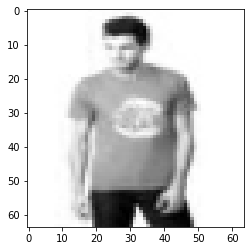

In [108]:
#PROBAMOS A PREDECIR 1 DE LAS IMAGENES DEL TEST_LOADER
import matplotlib.pyplot as plt 

batch=next(iter(test_loader_imageNet)) #cogemos 1 lote, batch=[[imgs],[labels]]
imgs, labels= batch[0],batch[1]
im=imgs[1]
label=labels[1]
plt.imshow(im.numpy()[0], cmap='gray')
print("valor esperado:",classDic[label.item()])

In [109]:
output = resnet18_model(im.unsqueeze(0).to(device))
_, predicted = torch.max(output, 1)
etiqueta =classDic[predicted.item()]
print('Valor predicho: ',etiqueta )

Valor predicho:  CasualMen


In [110]:

import time

##Testing

start_time = time.time()
criterion = nn.CrossEntropyLoss()


#Calculamos la acc y loss del modelo 
with torch.no_grad():
        correct = 0
        total = 0
        total_loss=0
        resnet18_model.eval()
        for data, target in test_loader_imageNet: #vamos iterando los distintos lotes del test_loader
            images = data
            labels =target
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = resnet18_model(images)
            total_loss += criterion(outputs,labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        print('loss',total_loss/len(test_loader_imageNet))


Test Accuracy of the model: 81.67993177942013 %
loss 0.5705740122632547


# Fine Tuning con vgg16

In [136]:
# Definir el modelo ResNet-18
model = models.vgg16(pretrained=True)
#vgg16 tiene 7 capas lineales
num_ftrs = model.classifier[6].in_features #obtenemos el numero de neuronas de entrada de la capa de salida en vgg
model.classifier[6] = nn.Linear(num_ftrs, 25) #sustituimos la capa final por una con 25 neuronas
model = model.to(device)

# Definir la función de pérdida y el optimizador (utilizo las mismas que en mi modelo)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)



In [137]:

num_epochs = 10
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader_imageNet):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_set_imageNet)  #divido por el tamaño del dataset, ya que una época recorre todo el dataset
    epoch_acc = running_corrects / len(train_set_imageNet) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch, epoch_loss, epoch_acc))

Epoch 0 running
[Train #0] Loss: 1.8320 Acc: 48.2667%
Epoch 1 running
[Train #1] Loss: 1.0085 Acc: 67.2133%
Epoch 2 running
[Train #2] Loss: 0.8293 Acc: 74.1333%
Epoch 3 running
[Train #3] Loss: 0.7581 Acc: 76.7867%
Epoch 4 running
[Train #4] Loss: 0.7016 Acc: 78.5133%
Epoch 5 running
[Train #5] Loss: 0.6624 Acc: 79.5467%
Epoch 6 running
[Train #6] Loss: 0.6326 Acc: 80.8567%
Epoch 7 running
[Train #7] Loss: 0.6148 Acc: 81.2100%
Epoch 8 running
[Train #8] Loss: 0.6257 Acc: 80.9067%
Epoch 9 running
[Train #9] Loss: 0.5854 Acc: 82.0900%


In [138]:
torch.save(model.state_dict(), "vgg16.pth")

In [139]:
vgg16_model = models.vgg16(pretrained=True)  
num_features = vgg16_model.classifier[6].in_features 
vgg16_model.classifier[6] = nn.Linear(num_features, 25)
vgg16_model.load_state_dict(torch.load("vgg16.pth"))
vgg16_model.to(device)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [140]:

import torchvision


##Testing

start_time = time.time()
criterion = nn.CrossEntropyLoss()


#Calculamos la acc y loss del modelo 
with torch.no_grad():
        correct = 0
        total = 0
        total_loss=0
        vgg16_model.eval()
        for data, target in test_loader_imageNet: #vamos iterando los distintos lotes del test_loader
            images = data
            labels =target
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = vgg16_model(images)
            total_loss += criterion(outputs,labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        print('loss',total_loss/len(test_loader_imageNet))

Test Accuracy of the model: 79.38459351904491 %
loss 0.6834015036171133


# Fine Tuning con densenet121

In [161]:
# Definir el modelo DenseNet-121
model = models.densenet121(pretrained=True)

# Modificamos la salida del modelo para adaptarse a 25 clases
num_ftrs = model.classifier.in_features #obtenemos el numero de neuronas de entrada de la capa de salida en DenseNet
model.classifier = nn.Linear(num_ftrs, 25) #sustituimos la capa final por una con 25 neuronas
model = model.to(device)
# Definir la función de pérdida y el optimizador (utilizo las mismas que en mi modelo)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [162]:
num_epochs = 30
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader_imageNet):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_set_imageNet)  #divido por el tamaño del dataset, ya que una época recorre todo el dataset
    epoch_acc = running_corrects / len(train_set_imageNet) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch, epoch_loss, epoch_acc))

Epoch 0 running
[Train #0] Loss: 0.8005 Acc: 74.0433%
Epoch 1 running
[Train #1] Loss: 0.6046 Acc: 79.7067%
Epoch 2 running
[Train #2] Loss: 0.5432 Acc: 81.6967%
Epoch 3 running
[Train #3] Loss: 0.4975 Acc: 83.2467%
Epoch 4 running
[Train #4] Loss: 0.4429 Acc: 84.8567%
Epoch 5 running
[Train #5] Loss: 0.3992 Acc: 86.2867%
Epoch 6 running
[Train #6] Loss: 0.3708 Acc: 87.0267%
Epoch 7 running
[Train #7] Loss: 0.3606 Acc: 87.5167%
Epoch 8 running
[Train #8] Loss: 0.3114 Acc: 88.7400%
Epoch 9 running
[Train #9] Loss: 0.3348 Acc: 88.5333%
Epoch 10 running
[Train #10] Loss: 0.2439 Acc: 91.3267%
Epoch 11 running
[Train #11] Loss: 0.2099 Acc: 92.3467%
Epoch 12 running
[Train #12] Loss: 0.1919 Acc: 93.2767%
Epoch 13 running
[Train #13] Loss: 0.1712 Acc: 93.8567%
Epoch 14 running
[Train #14] Loss: 0.1601 Acc: 94.1700%
Epoch 15 running
[Train #15] Loss: 0.1464 Acc: 94.7733%
Epoch 16 running
[Train #16] Loss: 0.1251 Acc: 95.4167%
Epoch 17 running
[Train #17] Loss: 0.1154 Acc: 95.7833%
Epoch 18 run

In [163]:
torch.save(model.state_dict(), "densenet121.pth")

In [164]:

densenet121_model = models.densenet121(pretrained=True)
num_ftrs = densenet121_model.classifier.in_features 
densenet121_model.classifier = nn.Linear(num_ftrs, 25) 

densenet121_model.load_state_dict(torch.load("densenet121.pth"))
densenet121_model = densenet121_model.to(device)

In [165]:

#Calculamos la acc y loss del modelo 
with torch.no_grad():
        correct = 0
        total = 0
        total_loss=0
        densenet121_model.eval()
        for data, target in test_loader_imageNet: #vamos iterando los distintos lotes del test_loader
            images = data
            labels =target
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = densenet121_model(images)
            total_loss += criterion(outputs,labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        print('loss',total_loss/len(test_loader_imageNet))

Test Accuracy of the model: 83.48493462194429 %
loss 0.9228364636952227


# PRUEBAS EN SUCIO Transfer Learning


In [ ]:

# Evaluamos el rendimiento de cada modelo en los mismos datos de prueba
model_list = [resnet18, vgg16, densenet121]
model_names = ["ResNet18", "VGG16", "DenseNet121"]

for model, model_name in zip(model_list, model_names):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, target in ImageNet_loader:
            images = data
            labels = target
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
        accuracy = correct / total
        print(f'Test Accuracy of {model_name}: {100 * accuracy:.2f}%')

# PRUEBAS EN SUCIO SIMILITUD


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [ ]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

In [ ]:
from torch.autograd import Variable
from PIL import Image
pic_one = '../input/fashion-product-images-small/images/10026.jpg'
pic_two = '../input/fashion-product-images-small/images/10024.jpg'
model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
model.eval()
to_tensor = transforms.ToTensor()
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
         my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

pic_one_vector = get_vector(pic_one)
pic_two_vector = get_vector(pic_two)
print(pic_one_vector.shape)

In [ ]:

# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(pic_one_vector.unsqueeze(0),
              pic_two_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))

In [ ]:
pip install img2vec-pytorch

# USANDO LIBRERIA IMAGE2VEC



In [ ]:
from img2vec_pytorch import Img2Vec

In [ ]:
 #Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True, model='resnet-18')

# Read in an image (rgb format)
img1 = Image.open('../input/fashion-product-images-small/images/10002.jpg')
img2 = Image.open('../input/fashion-product-images-small/images/10029.jpg')       
# Get a vector from img2vec, returned as a torch FloatTensor
vec1 = img2vec.get_vec(img1, tensor=True).reshape(512)
vec2 = img2vec.get_vec(img2, tensor=True).reshape(512)
print(vec1.shape)
print(img1)

In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(vec1.unsqueeze(0),
              vec2.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))